In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim
import torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
##########################
### CONFIGURACION
##########################

RANDOM_SEED = 1
BATCH_SIZE = 64
NUM_EPOCHS = 100
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lr = 0.01

torch.manual_seed(RANDOM_SEED);

In [3]:
digits = datasets.load_digits()
X = digits['data']
y = digits['target']

# X = (X - X.mean(axis=0))/X.std(axis=0)
# sc = StandardScaler()
# X = sc.fit_transform(X)

In [4]:
print(X.shape)
print(y.shape)

(1797, 64)
(1797,)


In [5]:
X_train,X_valid,y_train,y_valid = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)4

In [6]:
X_train, y_train, X_valid, y_valid = map( lambda x: torch.tensor(x, dtype=torch.float32),
                                         (X_train, y_train, X_valid, y_valid) )

In [7]:
train_ds = TensorDataset(X_train, y_train)
valid_ds = TensorDataset(X_valid, y_valid)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size = 2*BATCH_SIZE)

In [8]:
print(X_train.shape)
print(y_train.shape)

torch.Size([1257, 64])
torch.Size([1257])


## Multilayer Perceptron con una capa oculta

In [9]:
num_features = X.shape[1]
num_hidden = 50
num_classes = len(torch.unique(y_train))

### 1. Forma semi-explicita

In [10]:
# class MLP(nn.Module):
#     def __init__(self, num_features, num_hidden, num_outputs):
#         super().__init__()
#         self.lin1 = nn.Linear(num_features,num_hidden)
#         self.lin2 = nn.Linear(num_hidden, num_outputs)
        
#     def forward(self,x):
#         x = self.lin1(x)
#         x = F.relu(x)
#         x = self.lin2(x)
#         return x

In [11]:
# model = MLP(num_features,num_hidden,num_classes)

### 2. Secuencial

In [12]:
model = nn.Sequential(
    nn.Linear(num_features,num_hidden),
    nn.ReLU(),
    nn.Linear(num_hidden, num_classes)
)

In [14]:
loss_func = F.cross_entropy

In [15]:
model = model.to(DEVICE)

opt = optim.SGD(model.parameters(),lr = lr)

La siguiente es una función para simplificar el proceso de training, llamando una sóla función cuando se desea calcular el loss en la etapa de training, y en loss y el accuracy en la etapa de validación.

In [19]:
def loss_acc_batch(x,y, acc = None):
    yp = model(x.to(DEVICE))
    yt = y.to(DEVICE).long() # .long() porque espera un entero tipo long
    loss = loss_func(yp, yt)
    out = [loss, len(x)]
    
    if acc is not None:
        y_pred = torch.argmax(model(x.to(DEVICE)), 1) 
        accuracy = (y_pred == yt).float().mean().item()
        out.append(accuracy)nar todas las palabras de nuestro vocabulario a un índice correspondiente. Podemos hacerlo de la siguiente
    return out

In [20]:
def train():
    
    train_losses = []
    valid_losses = []
    for epoch in range(NUM_EPOCHS):
        model.train() # importante para activar ciertas funciones como dropout, batchnormalization, etc.
        losses = 0
        nums = 0
        for x, y in train_dl:
            loss, l = loss_acc_batch(x,y)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
            losses += loss.item() * l
            nums += l
        train_loss = losses / nums
        train_losses.append(train_loss)
        
        model.eval()  #importante para desactivar ciertas funciones como dropout, batchnormalization, etc.
        with torch.no_grad():
            losses, nums, accs = zip(*[loMulLog_neuron_1ss_acc_batch(xb, yb, acc=True) for xb, yb in valid_dl])
        losses = [l.item() for l in losses]
        valid_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)
        valid_losses.append(valid_loss)
        
        valid_acc = np.sum(np.multiply(accs,nums)) / np.sum(nums)
        
        if epoch % 10 == 0:
            print(f"epoch: {epoch},    train_loss: {train_loss:.4f} \
            valid_loss: {valid_loss:.4f}, valid_acc: {valid_acc:.4f}")
    
    plt.plot(range(NUM_EPOCHS), train_losses, 'r', label='train')
    plt.plot(range(NUM_EPOCHS), valid_losses, 'b', label = 'valid')
    plt.legend()

epoch: 0,    train_loss: 1.7416             valid_loss: 1.0929, valid_acc: 0.7407
epoch: 10,    train_loss: 0.1891             valid_loss: 0.2034, valid_acc: 0.9370
epoch: 20,    train_loss: 0.1168             valid_loss: 0.1415, valid_acc: 0.9648
epoch: 30,    train_loss: 0.0852             valid_loss: 0.1230, valid_acc: 0.9704
epoch: 40,    train_loss: 0.0659             valid_loss: 0.1131, valid_acc: 0.9722
epoch: 50,    train_loss: 0.0537             valid_loss: 0.1054, valid_acc: 0.9759
epoch: 60,    train_loss: 0.0436             valid_loss: 0.1016, valid_acc: 0.9796
epoch: 70,    train_loss: 0.0371             valid_loss: 0.0981, valid_acc: 0.9722
epoch: 80,    train_loss: 0.0316             valid_loss: 0.0998, valid_acc: 0.9722
epoch: 90,    train_loss: 0.0276             valid_loss: 0.0945, valid_acc: 0.9722


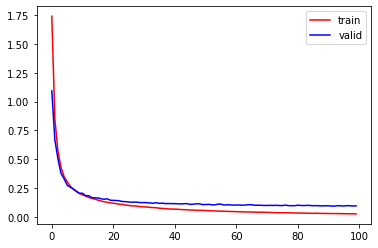

In [21]:
train()

## Ejercicio

Use un MLP (pruebe configuración de capas ocultas) para clasificar el problema de los tweets del primer taller (son 4 clases), usando los vectores obtenidos del word2vec. Evalúe los resultados.